# Import libraries

In [1]:
from util import *
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange 

# Loading images

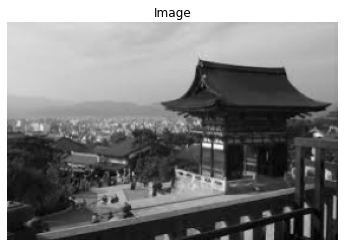

shape (184, 280, 3)


In [2]:
img = cv2.cvtColor(cv2.imread("kyoto.bmp"), cv2.COLOR_BGR2RGB)
img = cv2.resize(img.astype('int16'), (280, 184), interpolation = cv2.INTER_AREA)

plt.title('Image')
plt.imshow(img)
plt.axis('off')
plt.show()

print('shape', img.shape)

[[1 1 0 0 1 1 0 0]
 [1 0 1 0 0 0 0 0]
 [1 1 1 0 1 1 0 1]
 [1 0 0 0 0 1 1 1]
 [0 1 1 0 1 0 1 1]
 [1 0 1 0 1 1 1 0]
 [1 0 0 0 0 0 0 1]
 [0 1 0 1 0 1 1 1]]


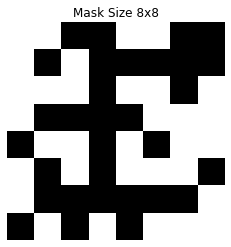

In [3]:
mask_size = 8
mask = np.random.randint(low=0, high=2, size=(mask_size, mask_size))
print(mask)

plt.title('Mask Size %dx%d'%(mask_size, mask_size))
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

# Random scattering

In [4]:
r_m, s_m, r_neg_m, s_neg_m = [], [], [], []

In [5]:
print(calculate_count_groups(img[:,:,0], -mask))
print(calculate_count_groups(img[:,:,0], mask))

(0.7515527950310559, 0.18509316770186335)
(0.7614906832298136, 0.168944099378882)


In [6]:
range_iter =trange(10, leave=True)

channels = [img[:, :, k] for k in range(img.shape[2])]

for i in range_iter:
    temp_rm, temp_sm, temp_r_neg_m, temp_s_neg_m = 0, 0, 0, 0
    for channel in channels:
        img_encoded = scattered_lsb_flipping(channel, 0.1*i)
        
        temp_1, temp_2 = calculate_count_groups(img_encoded, mask)
        temp_rm += temp_1
        temp_sm += temp_2
        
        temp_1, temp_2 = calculate_count_groups(img_encoded, -mask)
        
        temp_r_neg_m += temp_1
        temp_s_neg_m += temp_2
        
    r_m.append(temp_rm / len(channels)); r_neg_m.append(temp_r_neg_m / len(channels))
    s_m.append(temp_sm / len(channels)); s_neg_m.append(temp_s_neg_m / len(channels))
    
    range_iter.set_postfix_str('Rm->%f, R-m->%f, Sm->%f, S-m->%f'%(r_m[-1], r_neg_m[-1], s_m[-1], s_neg_m[-1]))
    range_iter.refresh()

100%|██████████| 10/10 [00:10<00:00,  1.07s/it, Rm->0.380124, R-m->0.843064, Sm->0.517184, S-m->0.113872]


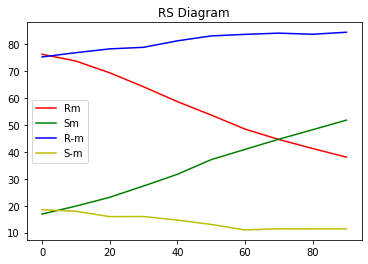

In [11]:
plt.title('RS Diagram')

plt.plot(range(0, 10*len(r_m), 10), 100*np.array(r_m), 'r', label = "Rm")
plt.plot(range(0, 10*len(s_m), 10), 100*np.array(s_m), 'g', label = 'Sm')
plt.plot(range(0, 10*len(r_neg_m), 10), 100*np.array(r_neg_m), 'b', label = 'R-m')
plt.plot(range(0, 10*len(s_neg_m), 10), 100*np.array(s_neg_m), 'y', label = 'S-m')
plt.legend()

plt.show()